<a href="https://colab.research.google.com/github/deepanshug77/Image_Captioning/blob/deepanshu/final_image_captioning_deepanshu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMAGE CAPTIONING

IMPORTING ALL LIBRARIES

In [ ]:
import tensorflow as tf
from tqdm import tqdm
from glob import glob
import cv2
import pickle
import nltk
import string
import pickle
import warnings
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive

/content/gdrive


In [ ]:
ls 


MyDrive/  Shareddrives/


In [ ]:
% cd MyDrive/

/content/gdrive/MyDrive


In [ ]:
% cd kaggle/

/content/gdrive/MyDrive/kaggle


In [ ]:
ls

flickr30k_images/  kaggle.json


In [ ]:
% cd flickr30k_images

/content/gdrive/MyDrive/kaggle/flickr30k_images


In [ ]:
ls

Flickr30k_cap.txt  flickr30k_images/  Flickr30k_IMG.txt  results.csv


In [ ]:
%cd flickr30k_images/

/content/gdrive/MyDrive/kaggle/flickr30k_images/flickr30k_images


# DECLARING CONSTANTS

In [ ]:
# Batch size for the encoder 
BATCH_SIZE_ENC = 50
# Batch size for the decoder
BATCH_SIZE_DEC = 100
# Buffer size
BUFFER_SIZE = 1000

In [ ]:
# image height according the the model architecture
IMG_H = 224
# image width according the the model architecture
IMG_W = 224

In [ ]:
# Dir which contains all the images. 
IMG_FILE_PATH = "/content/gdrive/My Drive/kaggle/flickr30k_images/flickr30k_images/"

In [ ]:
IMG_NAMES_TEXT_PATH = r"/content/gdrive/MyDrive/kaggle/flickr30k_images/Flickr30k_IMG.txt"
CAP_TEXT_PATH = r"/content/gdrive/MyDrive/kaggle/flickr30k_images/Flickr30k_cap.txt"

# LOADING ALL THE FUNCTIONS

In [ ]:
images_path_list = glob(IMG_FILE_PATH + '*.jpg')

In [ ]:
image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

print(image_features_extract_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
print(f"{len(images_path_list)} images found from {IMG_FILE_PATH}.")

31783 images found from /content/gdrive/My Drive/kaggle/flickr30k_images/flickr30k_images/.


In [ ]:
def load_img(image_path: str, img_h: str = IMG_H, img_w: str = IMG_W) -> (object, str):
    """
    Returns the numpy image and the image path
    :param image_path: the path of the image
    :param img_w: the width of image taken into the cnn
    :param img_h: the height of image taken into the cnn
    :return: image and image_path
    """
    # Read the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # Resizing the image according the the model architecture
    img = tf.image.resize(img, (img_h, img_w))
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img, image_path

In [ ]:
def load_doc(filename: str) -> str:
    """
    to open the file as read only
    :param filename: name of the file
    :return: the entire text as a string
    """
    with open(filename, 'r') as file:
        text = file.read()
    return text

In [ ]:
def img_name_2_path(image_name: str, img_file_path: str = IMG_FILE_PATH, ext: str = r".jpg") -> str:
    """
    Converts the name of the image to image path
    :param image_name: The name of the image
    :param img_file_path: The path where the image is stored
    :param ext:The extension of the image default is .jpg
    :return: The image path
    """
    image_path = img_file_path + str(image_name) + ext
    return image_path

In [ ]:
def load_img_dataset(txt_path: str, batch_size=BATCH_SIZE_ENC):
    """
    To load the train or test dataset
    :param txt_path: The text file which has the names of the training images
    :param batch_size: The batch size for processing
    :return: image_dataset
    """
    img_name_vector = load_set(txt_path)
    img_path_list = map(img_name_2_path, img_name_vector)
    encode_train = sorted(img_path_list)
    image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
    image_dataset = image_dataset.map(load_img, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)
    return image_dataset

In [ ]:
def load_set(text_file_path: str) -> set:
    """
    to load a pre-defined list of photo names
    returns the names of the images form the set_text_file
    :param text_file_path:
    :return:
    """
    # user defined to load the document
    doc = load_doc(text_file_path)
    dataset = doc.split('\n')
    return set(dataset)

In [ ]:
image_train_dataset = load_img_dataset(IMG_NAMES_TEXT_PATH)

# Extracting features 

In [ ]:
if str(input("Do you want to extract the features of the images[y/Y]: ")).casefold() == 'y':
    for img, path in tqdm(image_train_dataset):
        batch_features = image_features_extract_model(img)
        batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
        for bf, p in zip(batch_features, path):
            path_of_feature = p.numpy().decode("utf-8")
            np.save(path_of_feature, bf.numpy())

In [ ]:
image_train_dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>

#captions


In [ ]:
def load_clean_cap(caption_txt_path: str, dataset: set) -> dict:
    """
    load clean descriptions into memory
    :param caption_txt_path: The path where the clean captions were saved
    :param dataset: the img names of the tining or test data set
    :return: dict of captions mapped with its curr name
    """
    doc = load_doc(caption_txt_path)
    clean_captions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split name and captions
        image_name, image_cap = tokens[0], " ".join(tokens[1:])
        # skip the images which are not in the set.
        if image_name in dataset:
            # creating a list
            if image_name not in clean_captions:
                clean_captions[image_name] = list()
            clean_captions[image_name].append(image_cap)
    return clean_captions


In [ ]:
IMG_NAMES_TEXT_PATH

'/content/gdrive/MyDrive/kaggle/flickr30k_images/Flickr30k_IMG.txt'

In [ ]:
train_img_names = sorted(load_set(IMG_NAMES_TEXT_PATH))

In [ ]:
train_img_names[:10]

['1000092795',
 '10002456',
 '1000268201',
 '1000344755',
 '1000366164',
 '1000523639',
 '1000919630',
 '10010052',
 '1001465944',
 '1001545525']

In [ ]:
CAP_TEXT_PATH

'/content/gdrive/MyDrive/kaggle/flickr30k_images/Flickr30k_cap.txt'

In [ ]:
train_img_cap = load_clean_cap(CAP_TEXT_PATH, train_img_names)

In [ ]:
len(train_img_cap)

31783

In [ ]:
def max_len(clean_captions: dict) -> int:
    """
    Returns the length of the caption with most words
    :param clean_captions: a dictionary of captions
    :return: length of the longest caption
    """
    # Converts a dictionary of clean captions and returns a list of captions.
    clean_captions_list = [caption.split() for captions in clean_captions.values()
                           for caption in captions]
    return max(len(caption) for caption in clean_captions_list)
    

In [ ]:
MAX_CAP_LEN = max_len(train_img_cap)
print(MAX_CAP_LEN)
MAX_CAP_LEN = 50

74


tokenizing words


In [ ]:
def create_tokenizer(captions_dict: dict, top_k: int = 5000) -> Tokenizer:
    """
    Fit a tokenizer given caption descriptions
    :param captions_dict: (dict) of clean captions
    :param top_k: number of words in vocabulary
    :return: tokenizer object
    """
    clean_captions_list = [caption for captions in captions_dict.values()
                           for caption in captions]
    tokenizer = Tokenizer(num_words=top_k, oov_token="<unk>")
    # Map '<pad>' to '0'
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    tokenizer.fit_on_texts(clean_captions_list)
    return tokenizer


    

In [ ]:
tokenizer = create_tokenizer(train_img_cap)

In [ ]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(VOCAB_SIZE)

16860


In [ ]:
def tokenize_cap(tokenizer: Tokenizer, captions_dict: dict, pad_len: int = MAX_CAP_LEN) -> dict:
    """
    Tokenizes the captions and
    :param pad_len: The maximum caption length in the whole dataset
    (should include both train and test dataset)
    :param tokenizer: Tokenizer object
    :param captions_dict: The dict of train/test cap which have to be tokenized
    :return: A dict of tokenized captions
    """
    pad_caps_dict = {img_name: pad_sequences(tokenizer.texts_to_sequences(captions), maxlen=pad_len, padding='post',truncating='post')
                     for img_name, captions in captions_dict.items()}
    return pad_caps_dict
      

In [ ]:
def path_cap_list(img_names_set: set, tokenizer: Tokenizer, captions_dict) -> (list, list):
    """
    a list of image paths and a list of captions for images with corresponding values
    Note: the captions will be tokenized and padded in this function
    :param img_names_set: The set on which the processing is done
    :param tokenizer: tokenizer
    :param captions_dict: clean captions for that set without any tokenization
    """
    tokenized_caps_dict = tokenize_cap(tokenizer, captions_dict)
    image_name_list = sorted(img_names_set)
    capt_list = [cap for name in image_name_list for cap in tokenized_caps_dict[name]]
    img_path_list = [img_name_2_path(name) for name in image_name_list for i in range(len(tokenized_caps_dict[name]))]
    return img_path_list, capt_list

In [ ]:
def create_dataset(img_path_list: str, cap_list: str) -> object:
    """
    :param img_path_list: The ordered list of img paths with duplication acc to number of captions  
    :param cap_list: the padded caption list with the curr order 
    :return: dataset 
    """
    dataset = tf.data.Dataset.from_tensor_slices((img_path_list, cap_list))
    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_npy, [item1, item2], [tf.float32, tf.int32]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Shuffle and batch
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE_DEC).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
def load_npy(image_path: str, cap: str) -> (str, str):
    """
    :returns image tensor vector with the image path 
    :param image_path: 
    :param cap: 
    """
    img_tensor = np.load(image_path.decode('utf-8') + '.npy')
    return img_tensor, cap

# train

In [ ]:
img_name_train, caption_train = path_cap_list(train_img_names, tokenizer, train_img_cap)

In [ ]:
train_dataset = create_dataset(img_name_train, caption_train)

In [ ]:
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1 
num_steps = len(train_img_names) // BATCH_SIZE_DEC 
EPOCHS = 20
# Shape from last layer of VGG-16 :(7,7,512)
# So, say there are 49 pixel locations now and each pixel is 512 dimensional
features_shape = 512
attention_features_shape = 49 

# MODEL


In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights
    

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#     self.cudnn = tf.compat.v1.keras.layers.CuDNNLSTM(self.units, 
#                                         return_sequences=True, 
#                                         return_state=True, 
#                                         recurrent_initializer='glorot_uniform')
    self.gru = tf.compat.v1.keras.layers.CuDNNGRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, MAX_CAP_LEN, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * MAX_CAP_LEN, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * MAX_CAP_LEN, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
decoder.gru

In [ ]:
encoder

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

# checkpoint


In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

# TRAIN

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['startofseq']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
# Loading weights 
encoder.load_weights("Encoder_train_1_30k.h5")
decoder.load_weights("Decoder_train_1_30k.h5")

In [ ]:
import time

In [ ]:
EPOCHS = 1

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 0.9522
Epoch 1 Batch 100 Loss 0.9352
Epoch 1 Batch 200 Loss 0.7898
Epoch 1 Batch 300 Loss 0.7913
Epoch 1 Batch 400 Loss 0.8793
Epoch 1 Batch 500 Loss 0.7482
Epoch 1 Batch 600 Loss 0.7342
Epoch 1 Batch 700 Loss 0.7428
Epoch 1 Batch 800 Loss 0.6772
Epoch 1 Batch 900 Loss 0.7049
Epoch 1 Batch 1000 Loss 0.7158
Epoch 1 Batch 1100 Loss 0.6745
Epoch 1 Batch 1200 Loss 0.7305
Epoch 1 Batch 1300 Loss 0.8418
Epoch 1 Batch 1400 Loss 0.7757
Epoch 1 Batch 1500 Loss 0.8156
Epoch 1 Batch 1600 Loss 0.9013
Epoch 1 Batch 1700 Loss 0.7170
Epoch 1 Batch 1800 Loss 0.8516
Epoch 1 Batch 1900 Loss 0.8143
Epoch 1 Batch 2000 Loss 0.7565
Epoch 1 Batch 2100 Loss 0.7624
Epoch 1 Batch 2200 Loss 0.8069
Epoch 1 Batch 2300 Loss 0.8972
Epoch 1 Batch 2400 Loss 0.9720
Epoch 1 Batch 2500 Loss 0.8362
Epoch 1 Batch 2600 Loss 0.8402
Epoch 1 Loss 6.785010
Time taken for 1 epoch 1690.62 sec



# CAPTION

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((MAX_CAP_LEN, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_img(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['startofseq']], 0)
    result = []

    for i in range(MAX_CAP_LEN):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == 'endofseq':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
image_name = train_img_names[np.random.randint(0, len(train_img_cap))]
img_path = img_name_2_path(image_name)
real_captions = train_img_cap[image_name]

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

Prediction Caption: an older woman stand next to the two singer is around center of an audience endofseq
Real Captions:
1) startofseq woman in knit cap and man in peacoat sit on subway laden with bag endofseq
2) startofseq two people wearing black sit on bench and look down endofseq
3) startofseq two woman are sitting with their purse in their lap endofseq
4) startofseq people in dark clothing sit together endofseq
5) startofseq three people sitting on bench endofseq


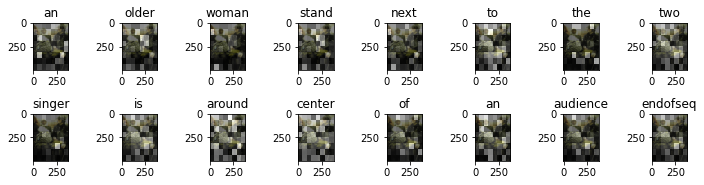

In [ ]:
result, attention_plot = evaluate(img_path)
print('Prediction Caption:', ' '.join(result))
print('Real Captions:')
for i, cap in enumerate(real_captions):
    print(f"{i+1}) {cap}")
plot_attention(img_path, result, attention_plot)

# WEIGHTS

In [ ]:
if os.path.isfile("Encoder_train_1_30k.h5") is False:
    encoder.save_weights("Encoder_train_1_30k.h5")
    print("Encoder saved")

In [ ]:
if os.path.isfile("Decoder_train_1_30k.h5") is False:
    decoder.save_weights("Decoder_train_1_30k.h5")
    print("Decoder saved")

# TESTING 

In [ ]:
img_path = str(input("Enter the image path: "))

In [ ]:
img_path

In [ ]:
result, attention_plot = evaluate(img_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(img_path, result, attention_plot)
# opening the image
Image.open(img_path)